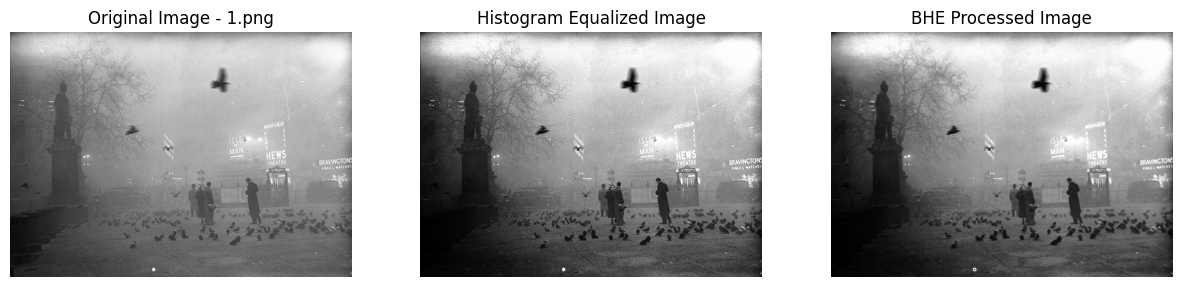

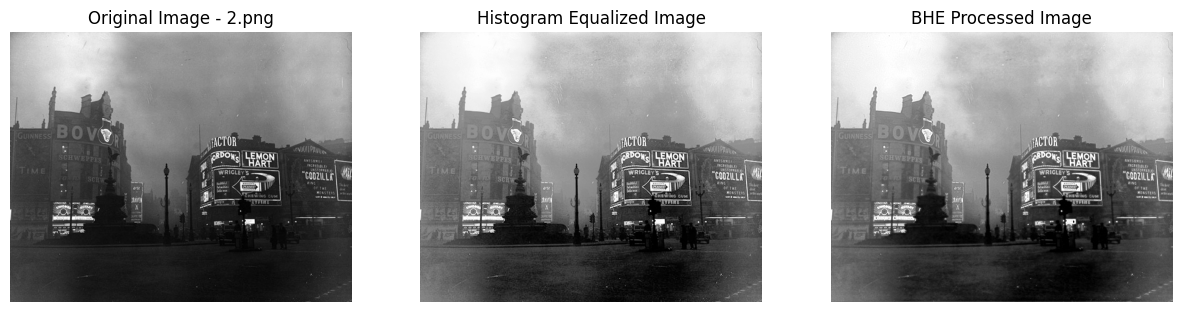

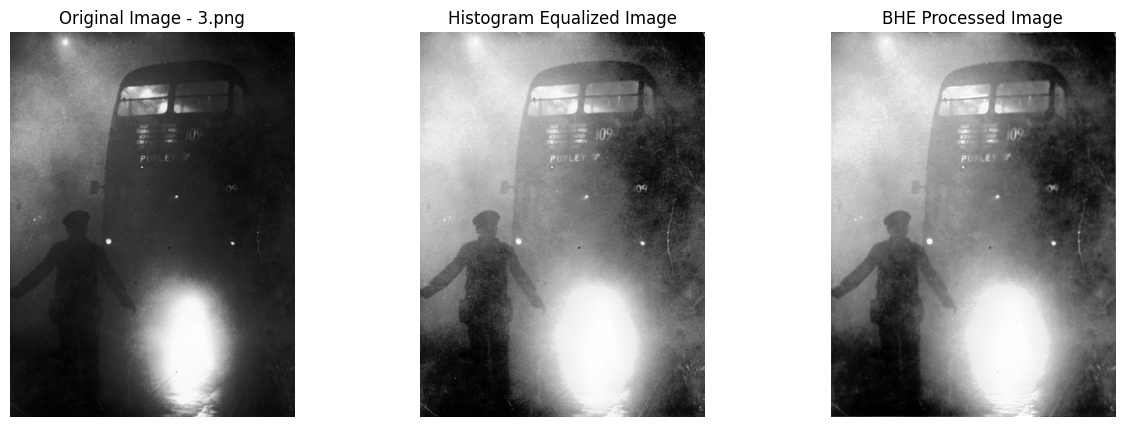

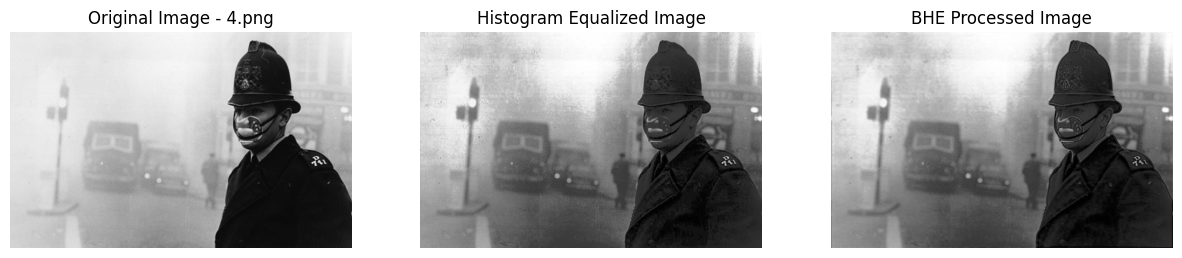

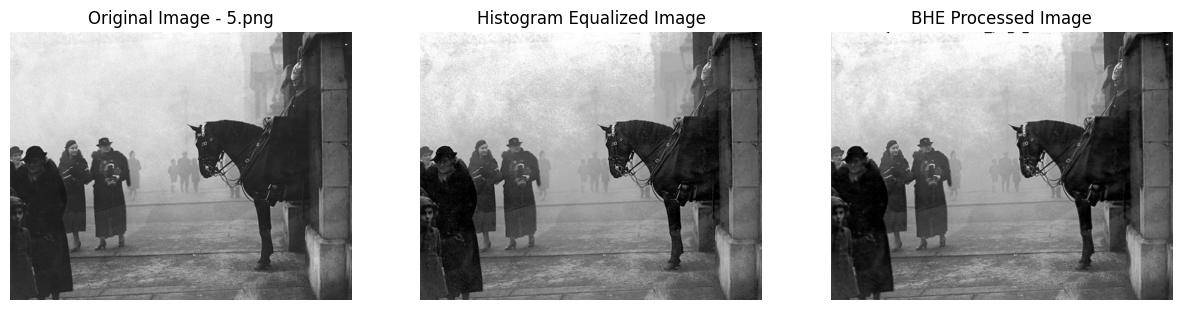

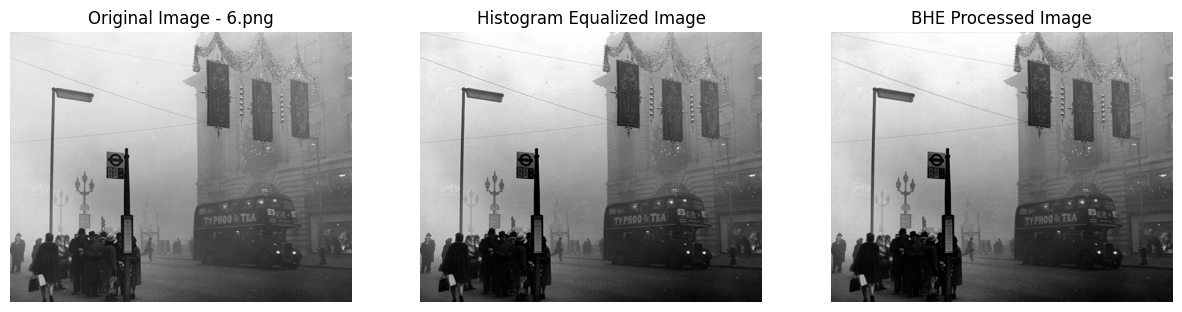

In [29]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def histogram_equalization(image):
    """ 对灰度图像进行直方图均衡化 """
    hist, bins = np.histogram(image.flatten(), 256, [0, 256])

    cdf = hist.cumsum()
    cdf_normalized = cdf * hist.max() / cdf.max()

    cdf_m = np.ma.masked_equal(cdf, 0)
    cdf_m = (cdf_m - cdf_m.min()) * 255 / (cdf_m.max() - cdf_m.min())
    cdf = np.ma.filled(cdf_m, 0).astype('uint8')

    img_equalized = cdf[image]

    return img_equalized

def butterworth_low_pass_filter(image, d0, n):
    """ 对图像应用巴特沃斯低通滤波器 """
    f = np.fft.fft2(image)
    fshift = np.fft.fftshift(f)

    rows, cols = image.shape
    crow, ccol = rows // 2, cols // 2

    D = np.zeros((rows, cols))
    for i in range(rows):
        for j in range(cols):
            D[i, j] = np.sqrt((i - crow) ** 2 + (j - ccol) ** 2)
    butterworth_filter = 1 / (1 + (D / d0) ** (2 * n))

    fshift_filtered = fshift * butterworth_filter
    f_ishift = np.fft.ifftshift(fshift_filtered)
    img_filtered = np.fft.ifft2(f_ishift)
    img_filtered = np.abs(img_filtered)

    return img_filtered

def bhe_algorithm(image, d0=90, n=2):
    """ 对图像进行巴特沃斯直方图均衡化处理 """
    low_freq_component = butterworth_low_pass_filter(image, d0, n)

    low_freq_eq = histogram_equalization(low_freq_component.astype('uint8'))

    high_freq_component = image - low_freq_component

    result = high_freq_component + low_freq_eq

    return result.clip(0, 255).astype('uint8')


image_filenames = ['1.png', '2.png', '3.png', '4.png', '5.png', '6.png']

for image_filename in image_filenames:
    sample_image = cv2.imread(image_filename, cv2.IMREAD_GRAYSCALE)
    
    if sample_image is not None:
        hist_eq_img = histogram_equalization(sample_image)
        
        bhe_img = bhe_algorithm(sample_image)

        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        axes[0].imshow(sample_image, cmap='gray')
        axes[0].set_title(f'Original Image - {image_filename}')
        axes[0].axis('off')
        
        axes[1].imshow(hist_eq_img, cmap='gray')
        axes[1].set_title('Histogram Equalized Image')
        axes[1].axis('off')
        
        axes[2].imshow(bhe_img, cmap='gray')
        axes[2].set_title('BHE Processed Image')
        axes[2].axis('off')
        
        plt.show()
    else:
        print(f"Image {image_filename} not found or unable to load.")

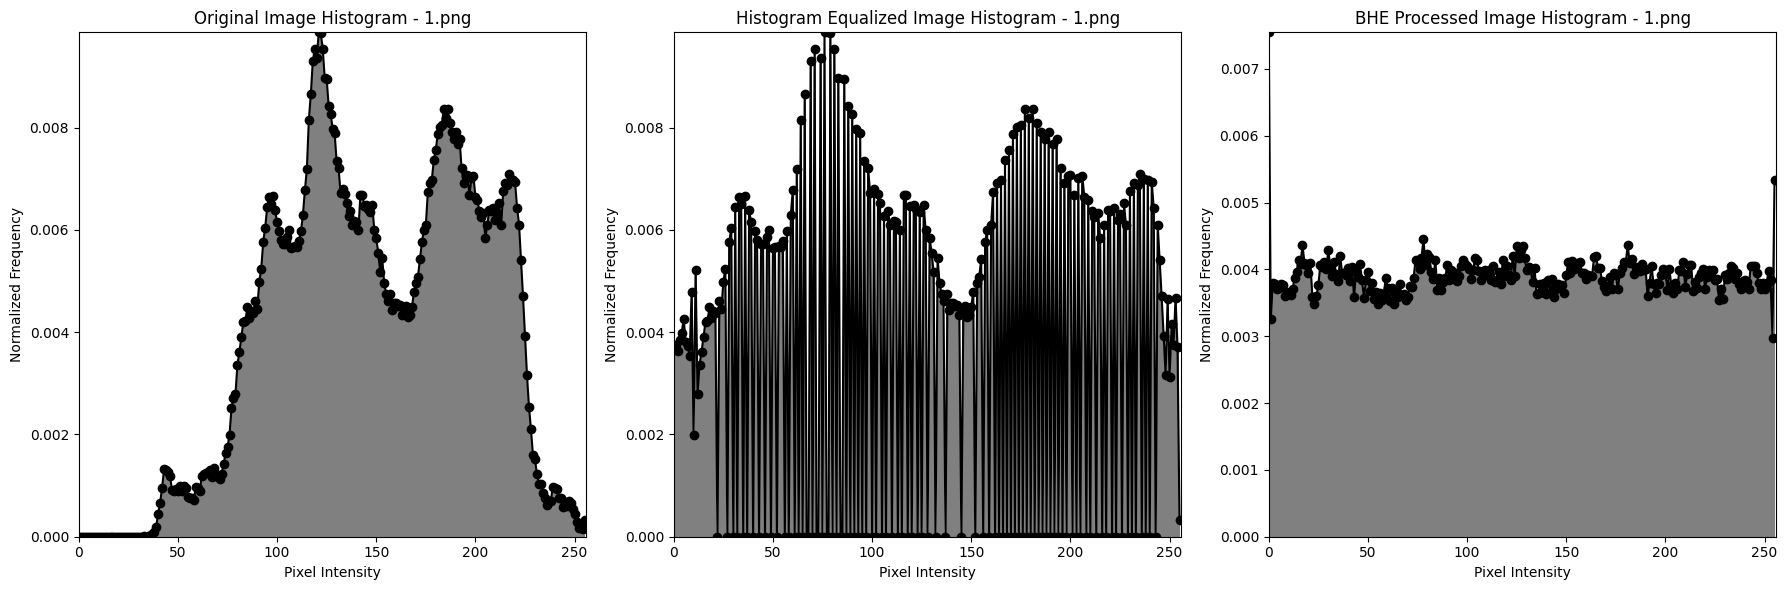

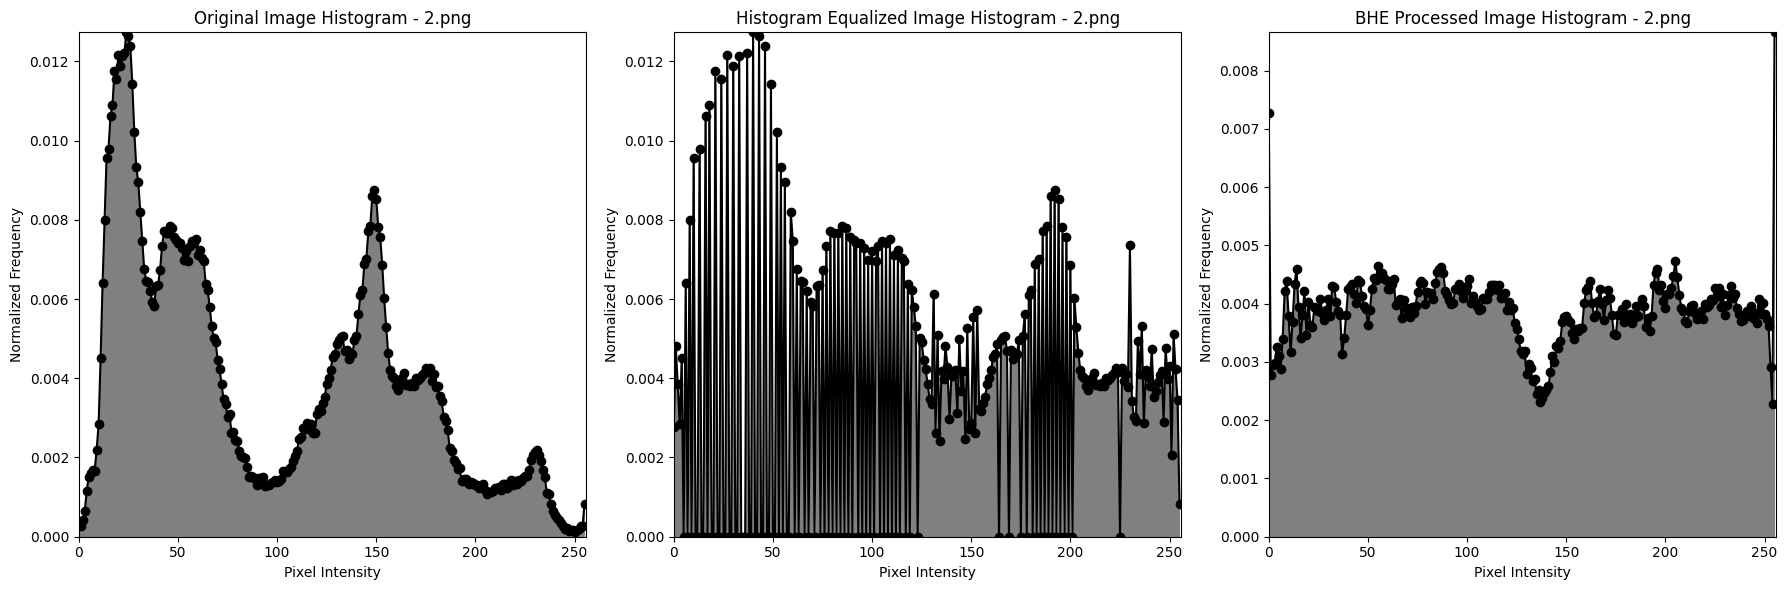

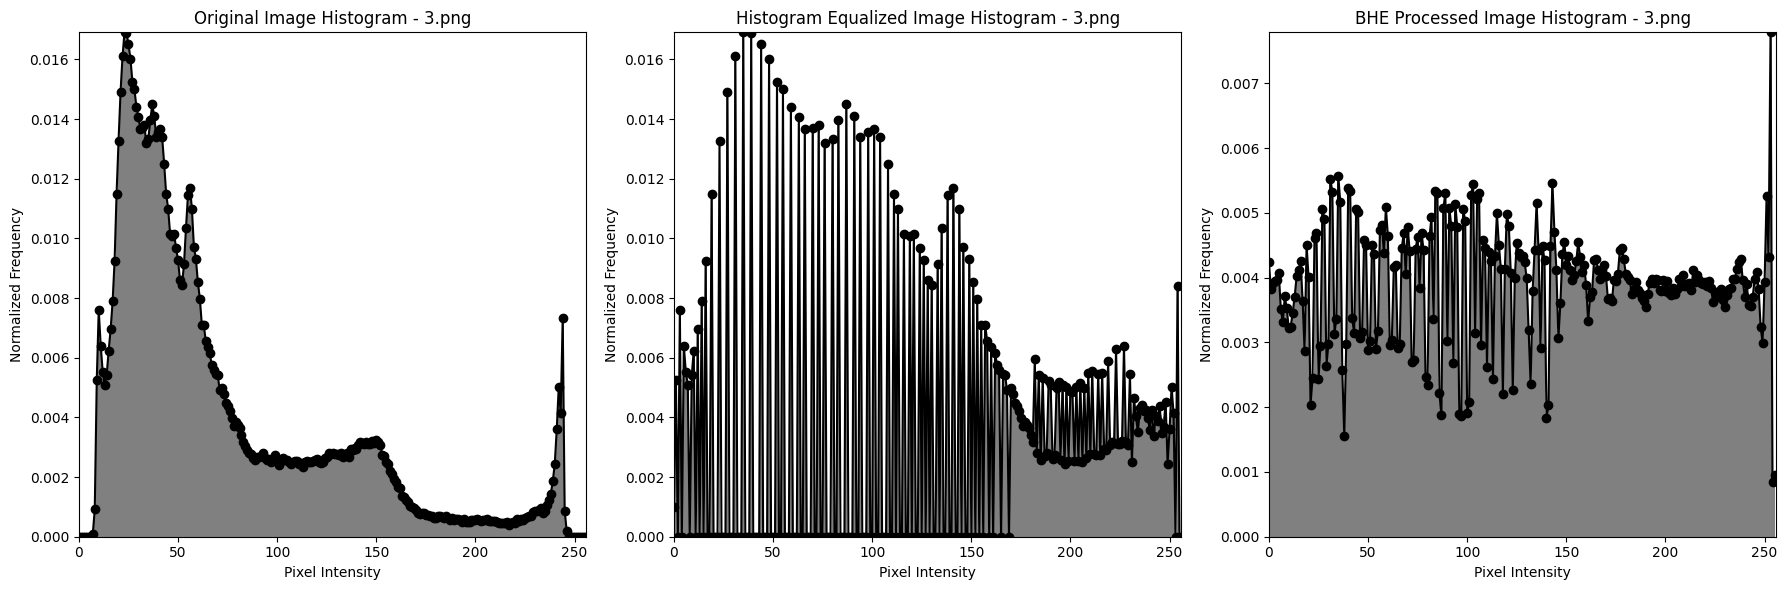

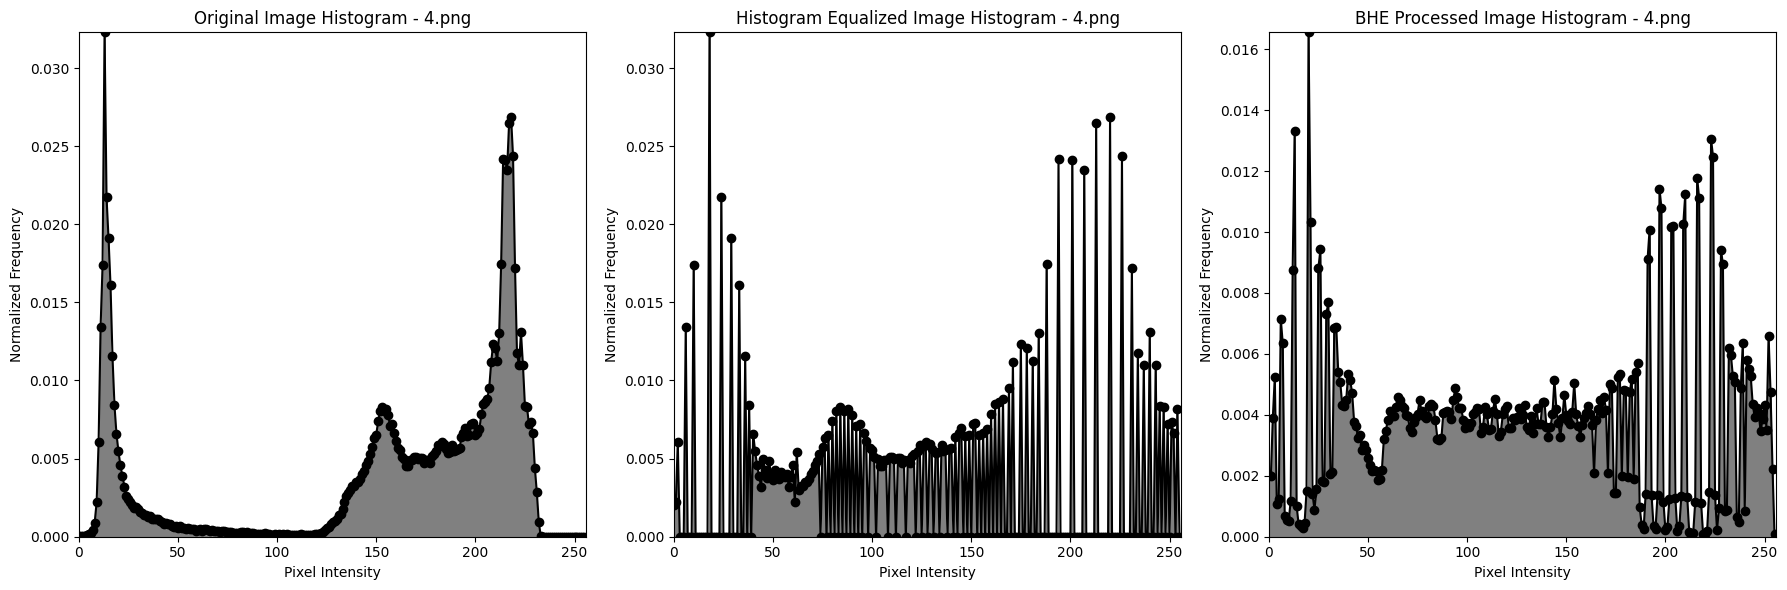

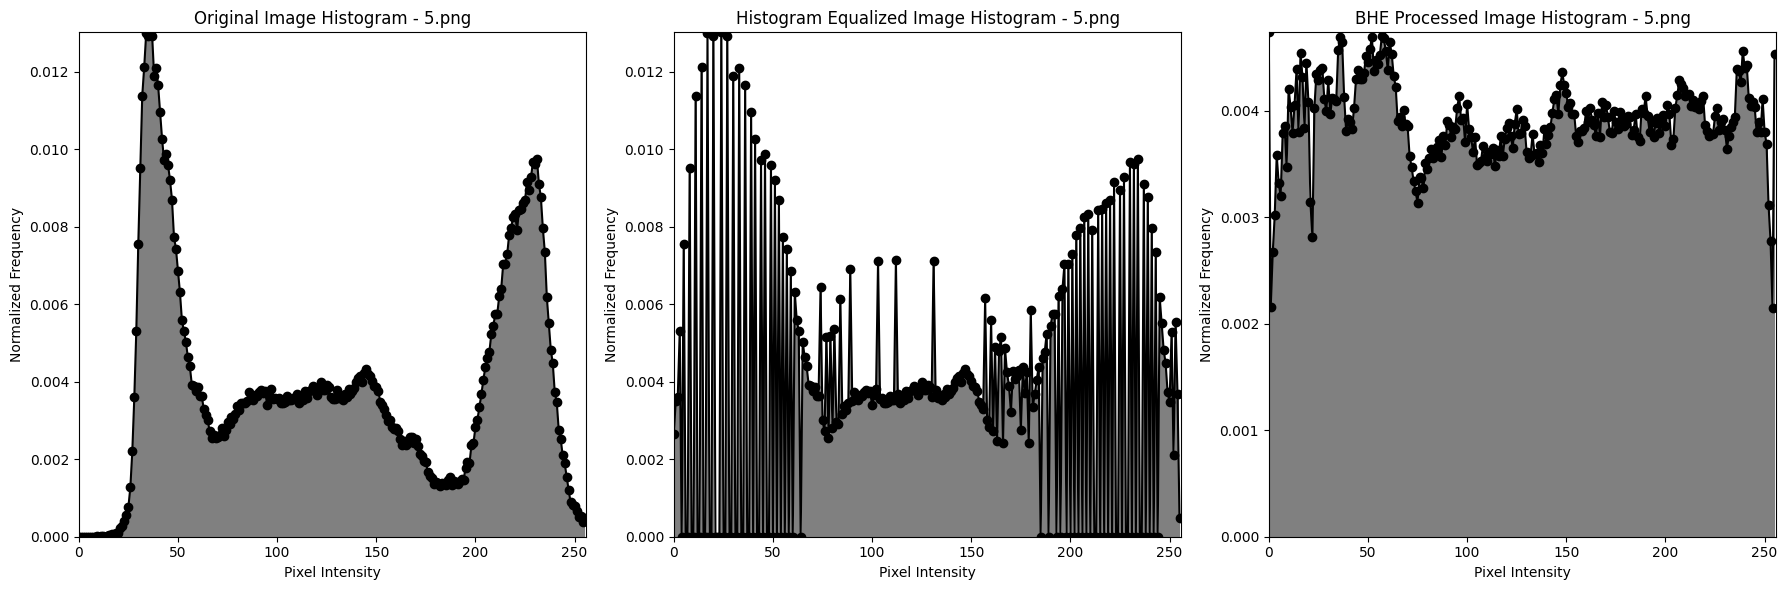

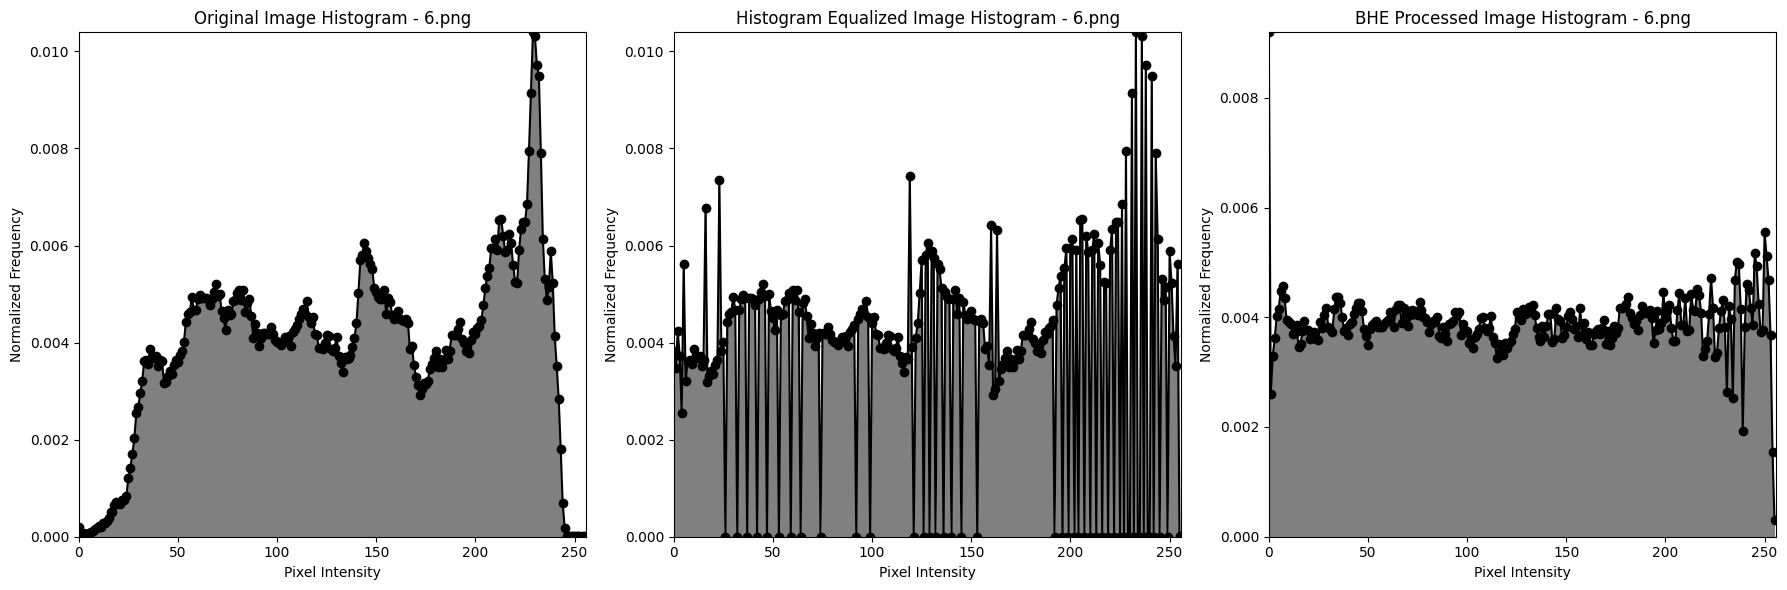

In [30]:
# 直方图函数
def plot_histogram(image, ax, title):
    hist, bins = np.histogram(image.flatten(), 256, [0, 256])
    ax.bar(bins[:-1], hist.astype('float') / hist.sum(), width=1, color='gray')
    ax.plot(bins[:-1], hist.astype('float') / hist.sum(), 'o-', color='black')
    ax.set_title(title)
    ax.set_xlim([0, 256])
    ax.set_ylim([0, hist.astype('float').max() / hist.sum()])
    ax.set_xlabel('Pixel Intensity')
    ax.set_ylabel('Normalized Frequency')
    

image_filenames = ['1.png', '2.png', '3.png', '4.png', '5.png', '6.png']

for image_filename in image_filenames:
    sample_image = cv2.imread(image_filename, cv2.IMREAD_GRAYSCALE)
    if sample_image is not None:
        hist_eq_img = histogram_equalization(sample_image)
        bhe_img = bhe_algorithm(sample_image)
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        plot_histogram(sample_image, axes[0], f'Original Image Histogram - {image_filename}')
        plot_histogram(hist_eq_img, axes[1], f'Histogram Equalized Image Histogram - {image_filename}')
        plot_histogram(bhe_img, axes[2], f'BHE Processed Image Histogram - {image_filename}')
        plt.tight_layout()
        plt.show()
    else:
        print(f"Image {image_filename} not found or unable to load.")

In [31]:
import numpy as np
import cv2
import math

def calculate_entropy(image):
    """计算图像的熵"""
    histogram = cv2.calcHist([image], [0], None, [256], [0, 256])
    histogram_normalized = histogram.ravel()/histogram.sum()
    entropy = -1 * (histogram_normalized[histogram_normalized > 0] * np.log2(histogram_normalized[histogram_normalized > 0])).sum()
    return entropy

def calculate_psnr(original, processed):
    """计算图像的峰值信噪比"""
    mse = np.mean((original - processed) ** 2)

    if mse == 0:
        return float('inf')

    return 20 * math.log10(255.0 / math.sqrt(mse))

image_filenames = ['1.png', '2.png', '3.png', '4.png', '5.png', '6.png']

metrics = []

for image_filename in image_filenames:
    original_image = cv2.imread(image_filename, cv2.IMREAD_GRAYSCALE)
    if original_image is not None:
        hist_eq_image = histogram_equalization(original_image)
        bhe_image = bhe_algorithm(original_image)

        entropy_original = calculate_entropy(original_image)
        entropy_hist_eq = calculate_entropy(hist_eq_image)
        entropy_bhe = calculate_entropy(bhe_image)

        psnr_hist_eq = calculate_psnr(original_image, hist_eq_image)
        psnr_bhe = calculate_psnr(original_image, bhe_image)

        metrics.append((image_filename, entropy_original, entropy_hist_eq, entropy_bhe, psnr_hist_eq, psnr_bhe))
    else:
        print(f"Image {image_filename} not found or unable to load.")

print(f"{'Image':<10} {'Entropy Original':<20} {'Entropy Hist EQ':<20} {'Entropy BHE':<20} {'PSNR Hist EQ':<20} {'PSNR BHE':<20}")
for metric in metrics:
    image_filename, entropy_original, entropy_hist_eq, entropy_bhe, psnr_hist_eq, psnr_bhe = metric
    print(f"{image_filename:<10} {entropy_original:<20.4f} {entropy_hist_eq:<20.4f} {entropy_bhe:<20.4f} {psnr_hist_eq:<20.4f} {psnr_bhe:<20.4f}")

Image      Entropy Original     Entropy Hist EQ      Entropy BHE          PSNR Hist EQ         PSNR BHE            
1.png      7.4540               7.3285               7.9958               28.0039              28.5173             
2.png      7.5895               7.3446               7.9841               28.2699              27.2381             
3.png      7.2379               6.9669               7.9614               27.4555              27.7898             
4.png      6.8840               6.7168               7.6833               28.0281              28.0302             
5.png      7.5978               7.4117               7.9931               30.6042              30.9476             
6.png      7.7693               7.6849               7.9839               27.9103              27.9867             
